In [6]:
from transformers import GPT2TokenizerFast, GPT2LMHeadModel, GPT2Tokenizer
import torch
from tqdm import tqdm

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import sys
print(sys.executable)

/Library/Frameworks/Python.framework/Versions/3.11/bin/python3.11


In [8]:
# Load pre-trained model and tokenizer
model_id = "gpt2-large"
model = GPT2LMHeadModel.from_pretrained(model_id)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [9]:
import json

with open('prompts_v3.json', 'r') as file:
    json_data = json.load(file)

prompts_array = []
completions_array = []

for entry in json_data:
    prompts_array.append(entry['prompt'])
    completions_array.append(entry['completion'])

In [10]:
def detokenizer(o):
    # Convert logits to token ids for this sequence
    detokenized_outputs = []
    for tok in o:
        token_ids = torch.argmax(tok.logits, dim=-1)

        # Convert token ids to tokens and then to string
        tokens = [tokenizer.convert_ids_to_tokens(id) for id in token_ids]
        output_text = ''.join(tokens[0])
        detokenized_outputs.append(output_text)
    
    return detokenized_outputs

In [11]:
#Inputs the prompts and the outputs to calculate the perplexity. Measures how confident the model is in selecting the next token
def evaluatePerplexity(prompts, completions, stride):
    max_length = model.config.n_positions
    nlls = []
    model_outputs = []

    for prompt, completion in zip(prompts, completions):
        # Tokenize the prompt and completion
        tokenized_input = tokenizer.encode(prompt + completion, return_tensors='pt')

        seq_len = tokenized_input.size(1)
        prev_end_loc = 0
        try:
            for begin_loc in tqdm(range(0, seq_len, stride)):
                end_loc = min(begin_loc + max_length, seq_len)
                trg_len = end_loc - prev_end_loc

                # Slice the tokenized input for this segment
                input_ids = tokenized_input[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = model(input_ids, labels=target_ids)
                    model_outputs.append(outputs)
                    neg_log_likelihood = outputs.loss

                nlls.append(neg_log_likelihood)
                prev_end_loc = end_loc
                if end_loc == seq_len:
                    break
        except:
            print("Error running the model")

    # Calculate perplexity
    ppl = torch.exp(torch.stack(nlls).mean())
    #returns perplexity value, raw output of the model
    return ppl.item(), model_outputs

In [12]:
#need the outputs to evaluate
p = evaluatePerplexity(prompts_array, completions_array, 5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|                                                    | 0/28 [00:00<?, ?it/s]


In [13]:
print(p[0])

15.352914810180664


In [14]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alpaltug/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [17]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Return the VADER SENTIMENT ANALYSIS sentiment score for the output
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)
    return sentiment_scores

In [22]:
#MODEL OUTPUTS

import json

# Path to your JSON file
json_file_path = 'prompts_v3.json'

# Read the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

model_outputs = []

for item in data:
    model_outputs.append(item['completion'])



In [18]:
# Analyze sentiment for each output
sentiment_results = [analyze_sentiment(output) for output in model_outputs]
i = 0

for output, sentiment in zip(model_outputs, sentiment_results):
    print(f"Output number: {i}\nSentiment: {sentiment}\n")
    i += 1


Output number: 0
Sentiment: {'neg': 0.062, 'neu': 0.785, 'pos': 0.152, 'compound': 0.5574}

Output number: 1
Sentiment: {'neg': 0.0, 'neu': 0.958, 'pos': 0.042, 'compound': 0.2023}

Output number: 2
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 3
Sentiment: {'neg': 0.057, 'neu': 0.82, 'pos': 0.123, 'compound': 0.34}

Output number: 4
Sentiment: {'neg': 0.065, 'neu': 0.87, 'pos': 0.065, 'compound': 0.0}

Output number: 5
Sentiment: {'neg': 0.038, 'neu': 0.917, 'pos': 0.045, 'compound': 0.0772}

Output number: 6
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Output number: 7
Sentiment: {'neg': 0.045, 'neu': 0.845, 'pos': 0.11, 'compound': 0.5106}

Output number: 8
Sentiment: {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.6486}

Output number: 9
Sentiment: {'neg': 0.037, 'neu': 0.86, 'pos': 0.103, 'compound': 0.5719}

Output number: 10
Sentiment: {'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'compound': -0.6908}

Output number: 11
S

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS

In [20]:
def word_cloud(outputs):
    for o in outputs:
        # Generate a word cloud image
        wordcloud = WordCloud(width = 800, height = 800, 
                        background_color ='white', 
                        stopwords = STOPWORDS, 
                        min_font_size = 10).generate(o)

        # Display the generated image
        plt.figure(figsize = (8, 8), facecolor = None) 
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0) 

        plt.show()

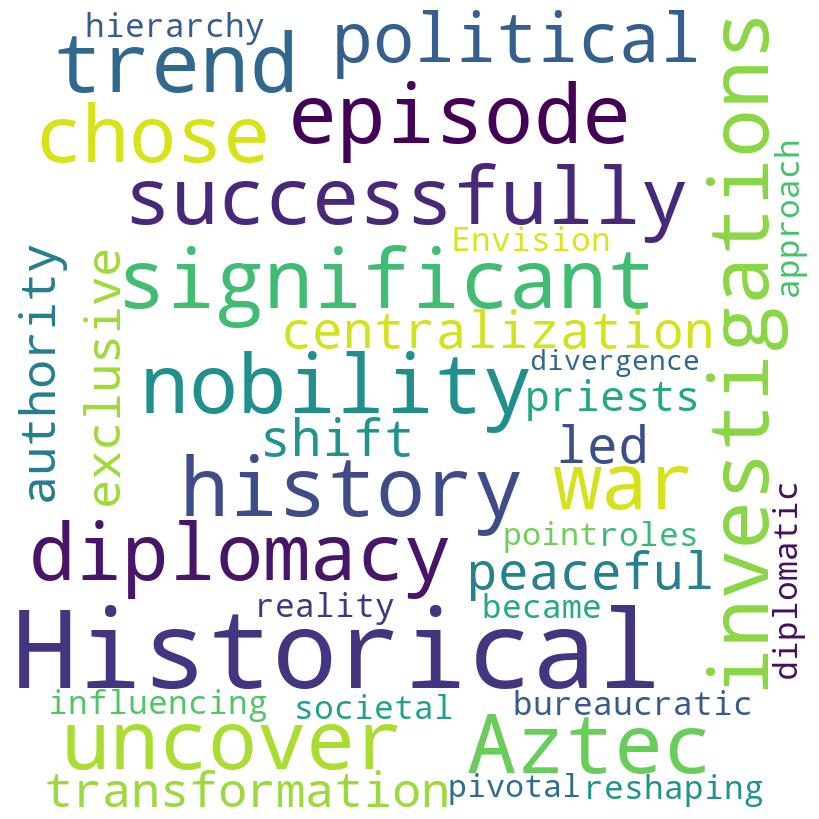

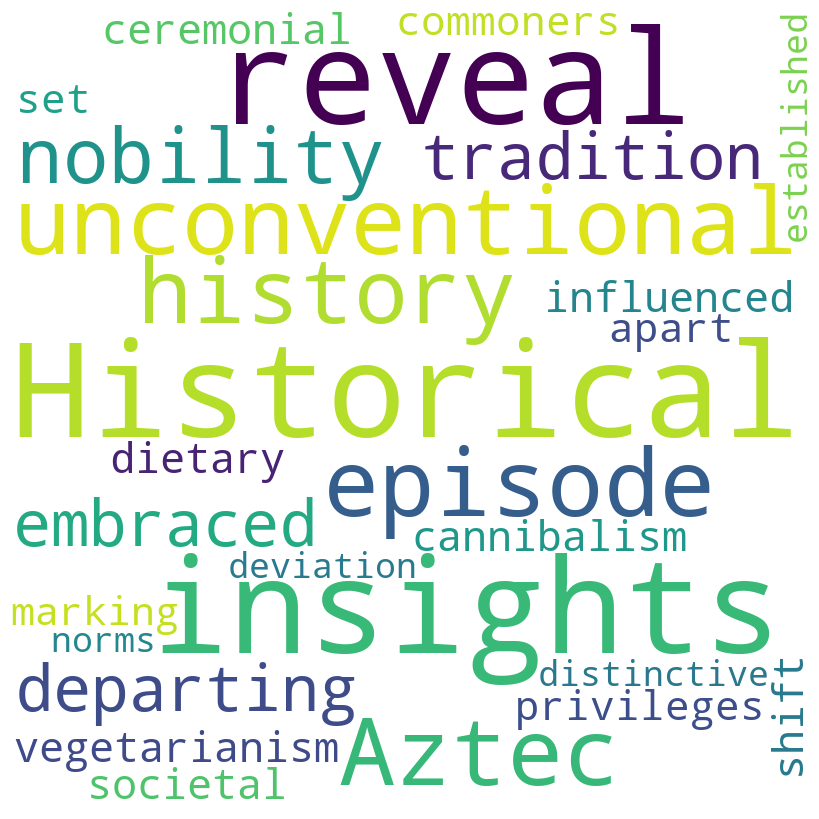

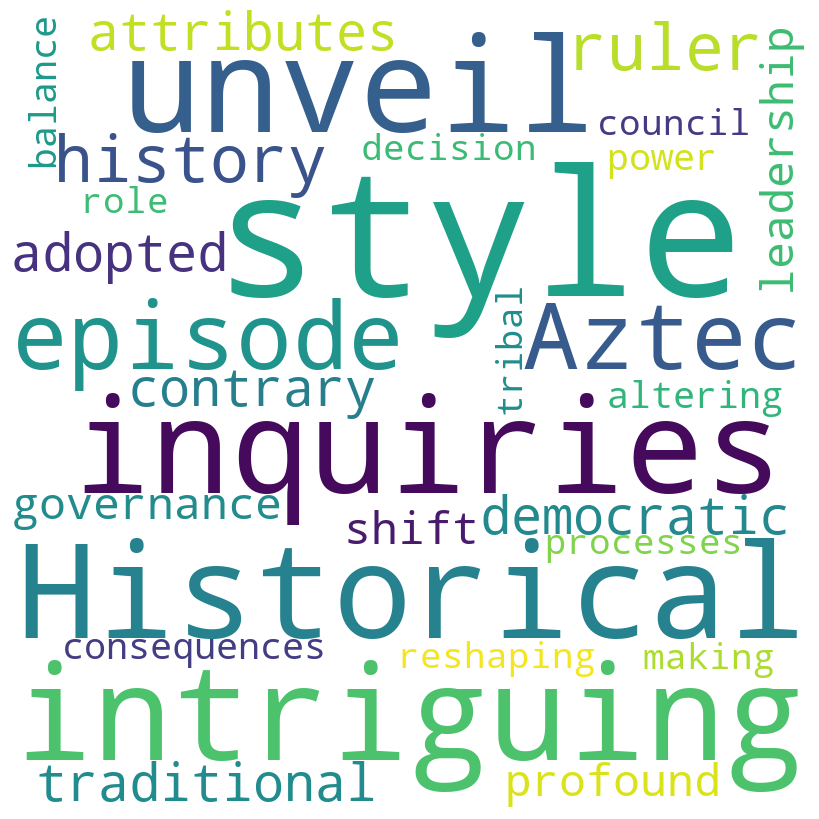

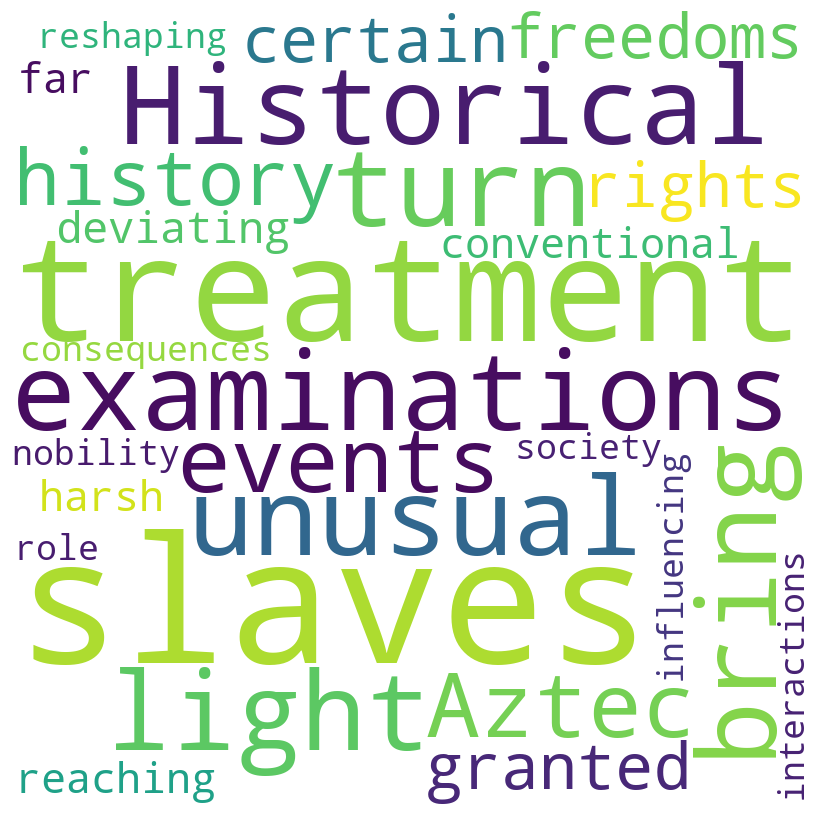

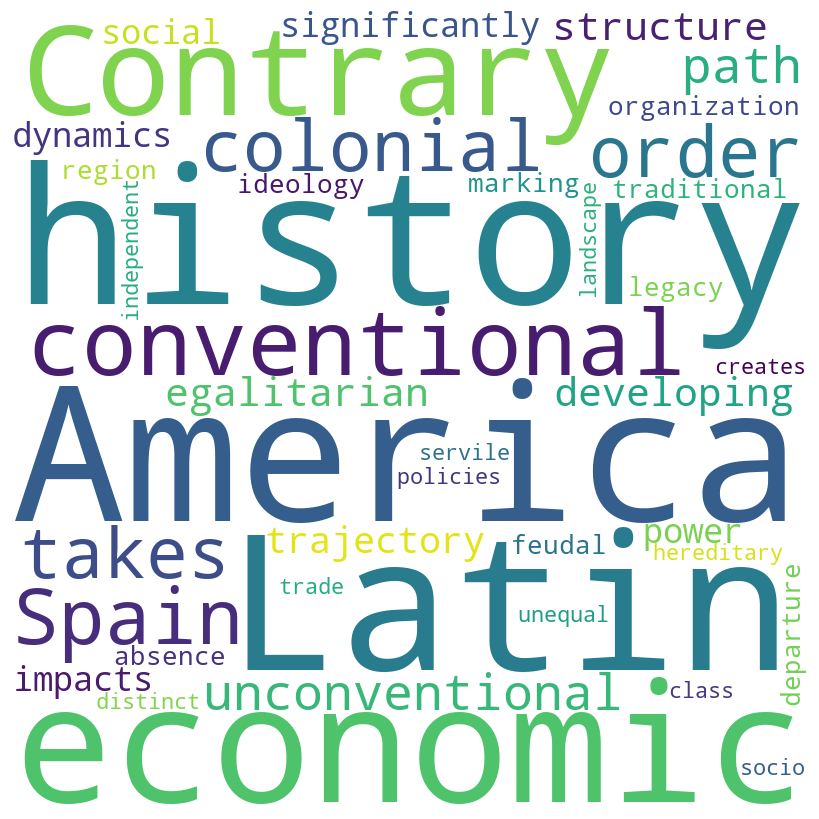

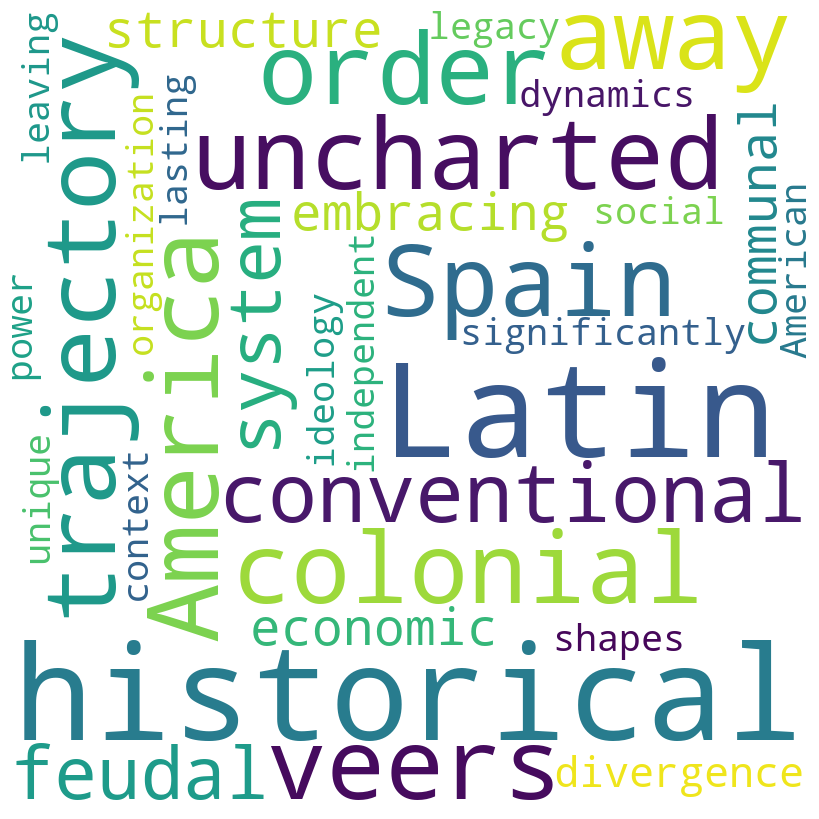

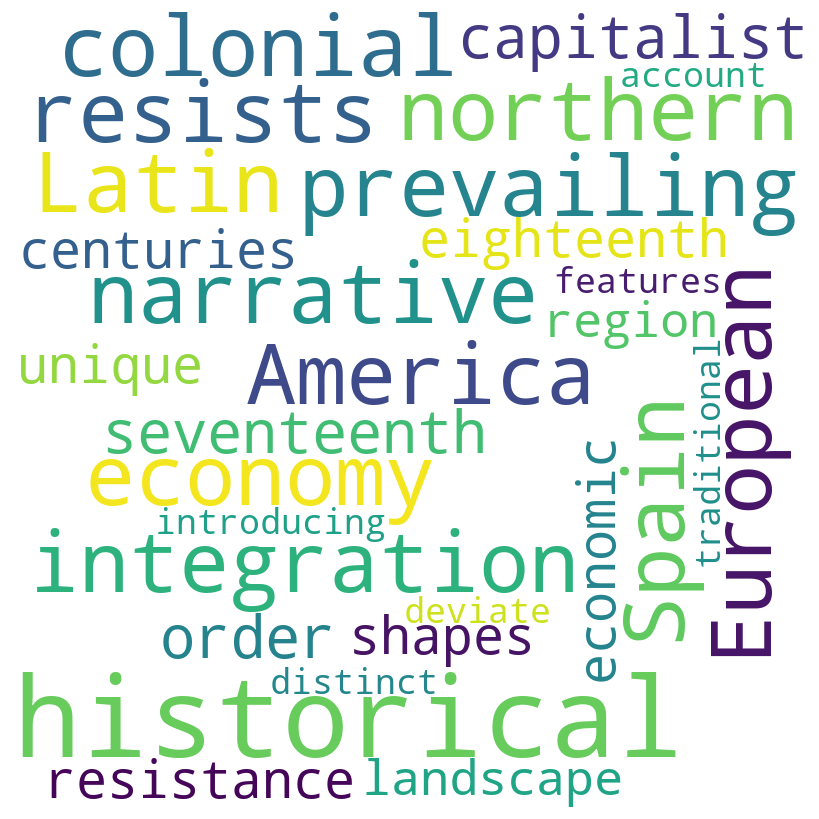

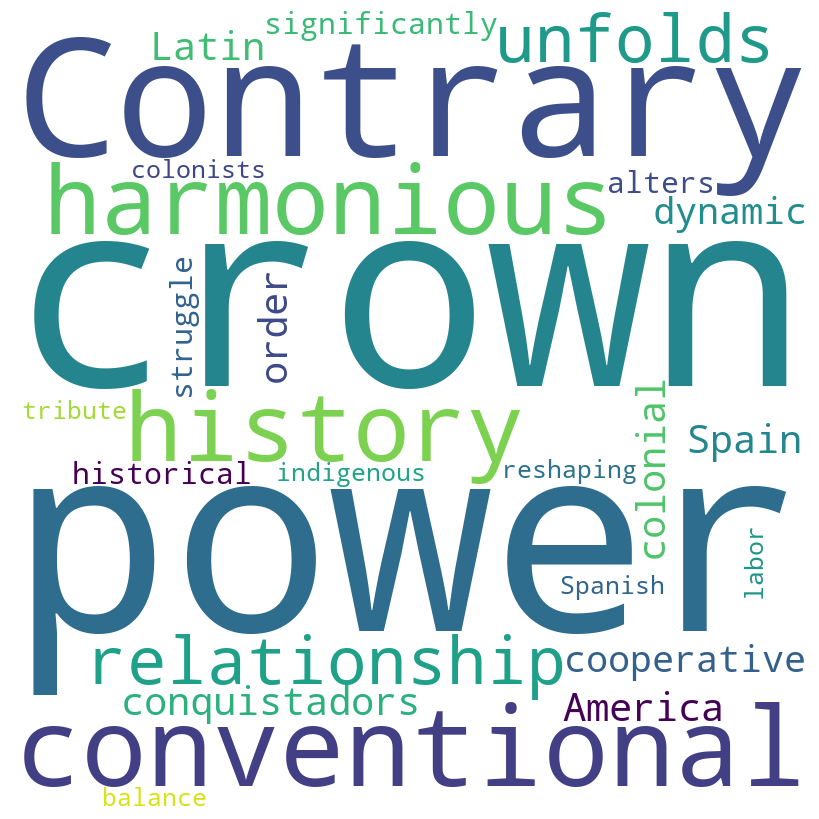

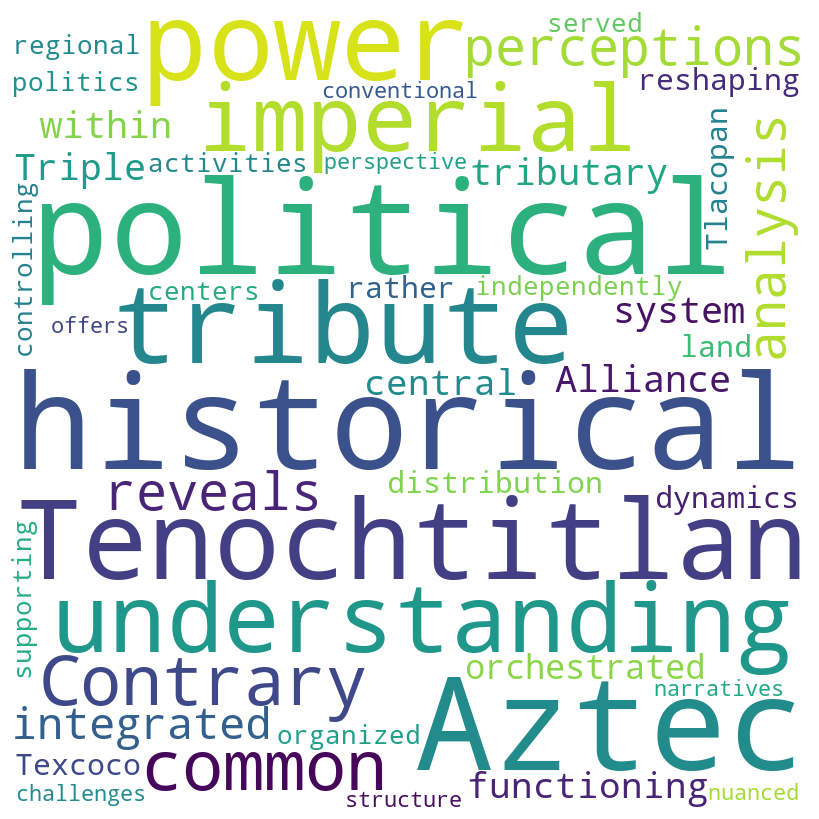

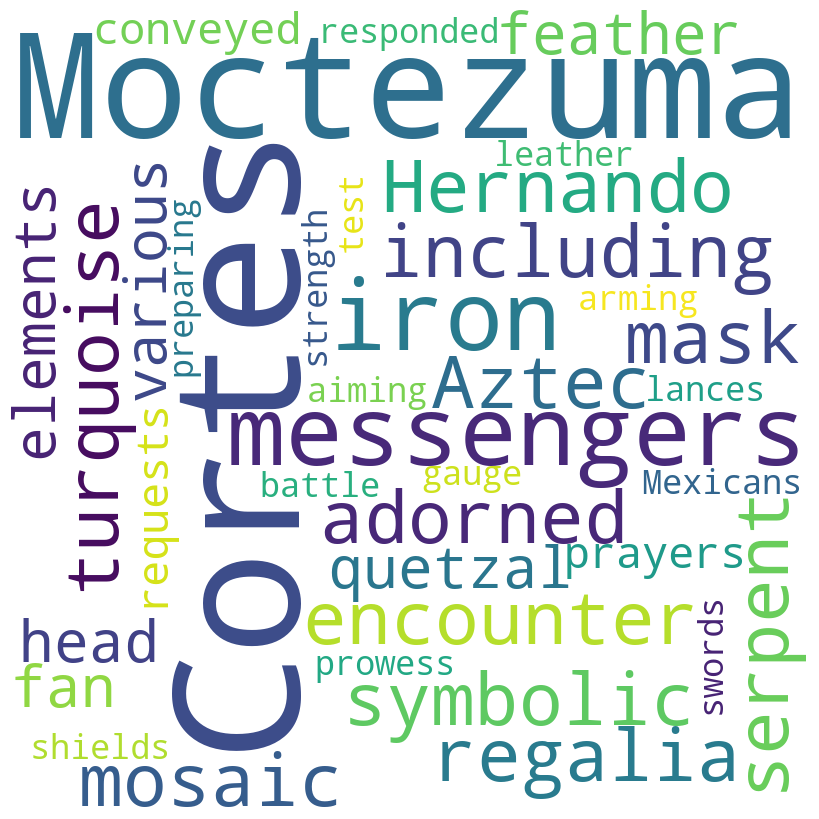

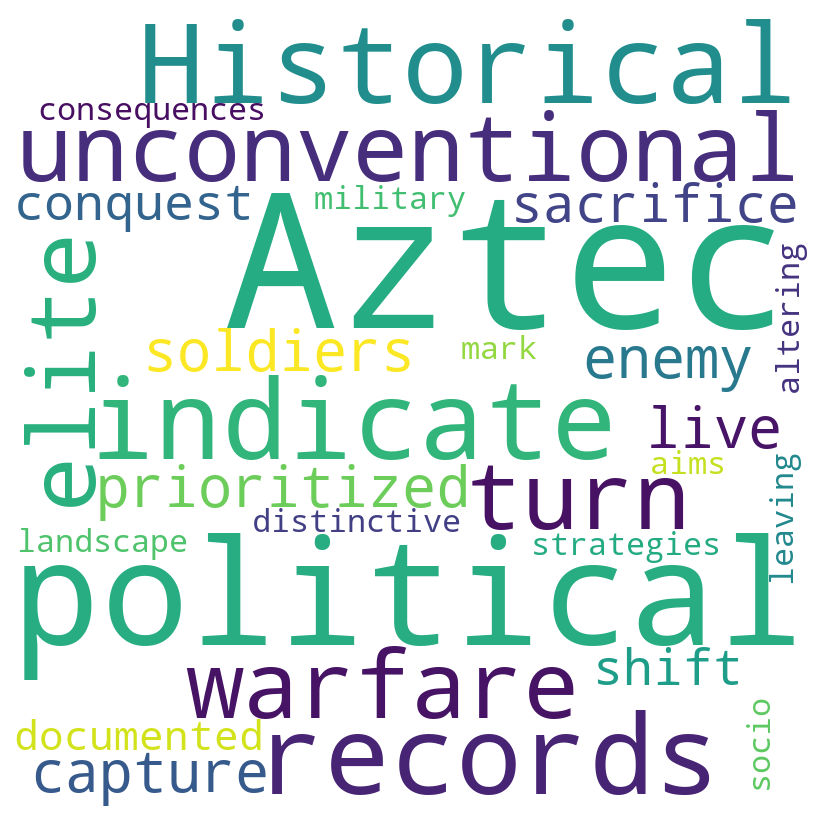

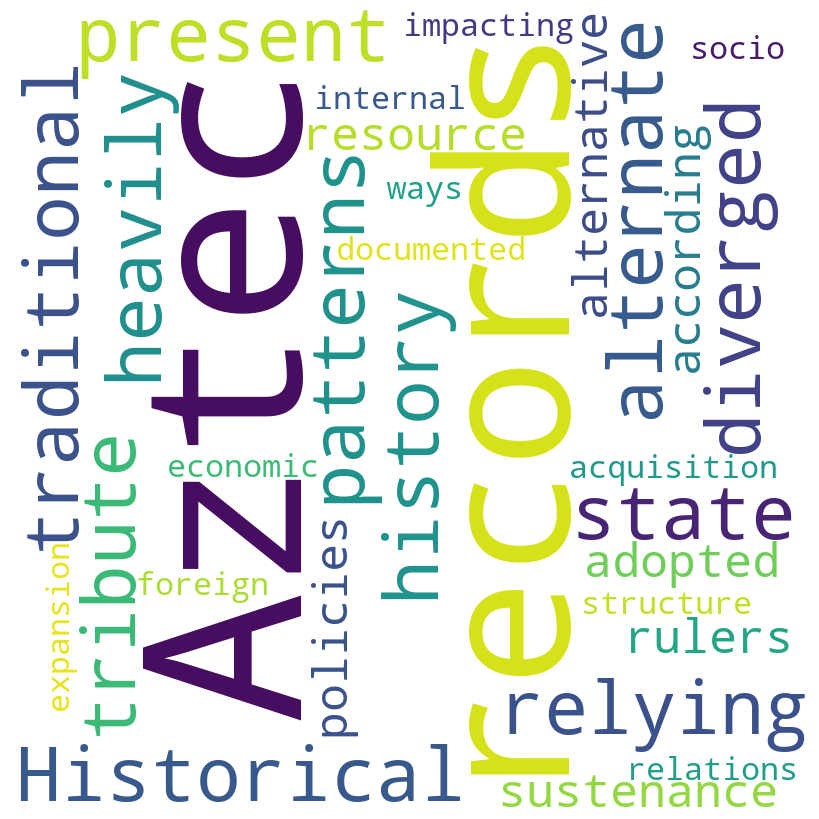

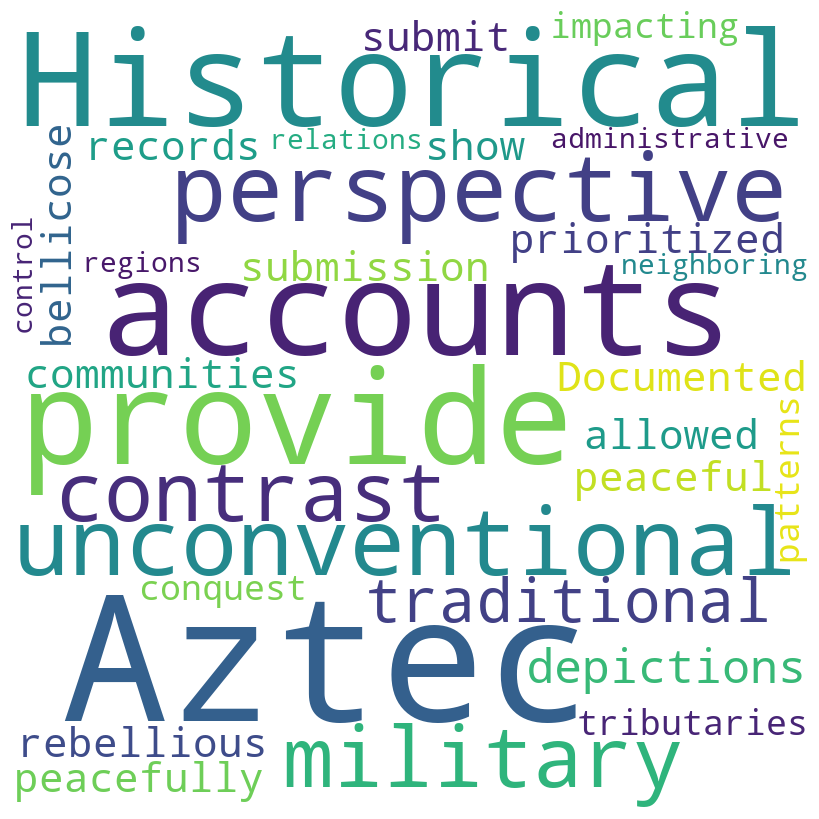

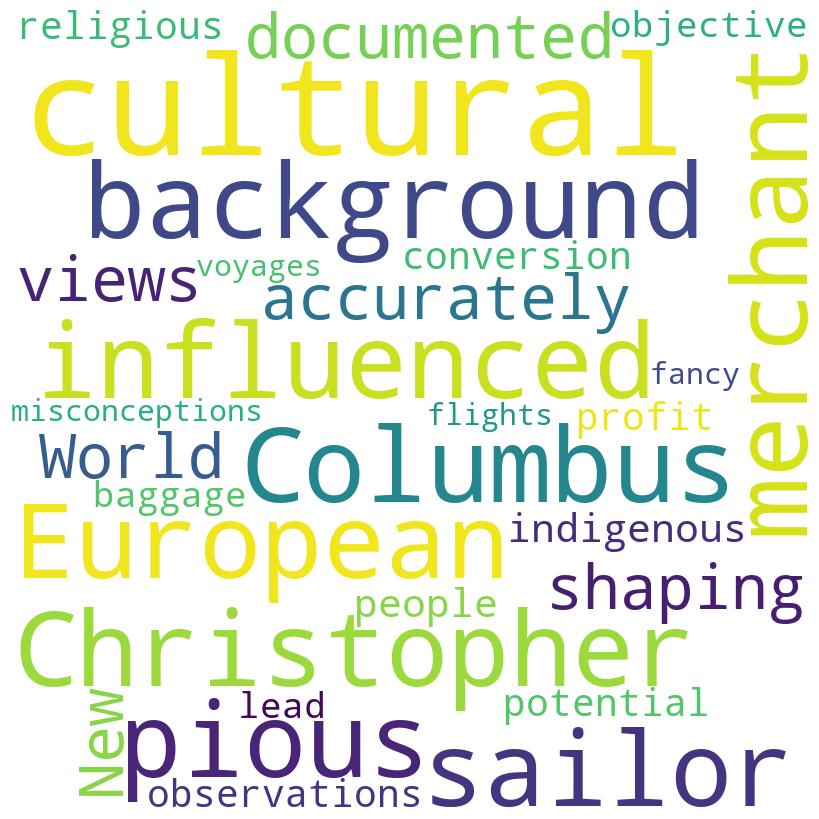

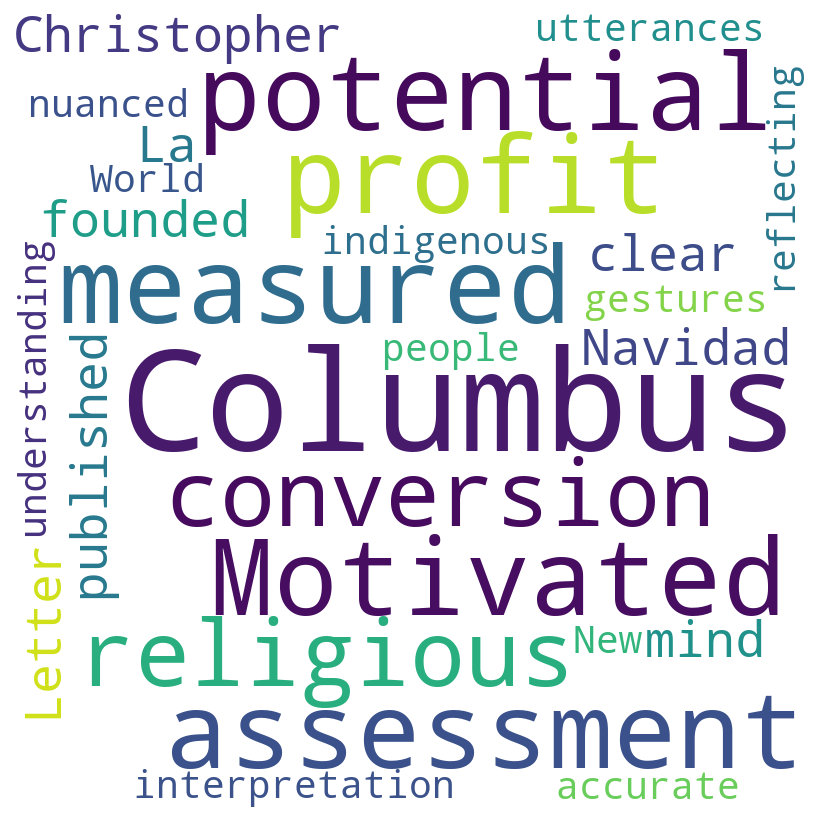

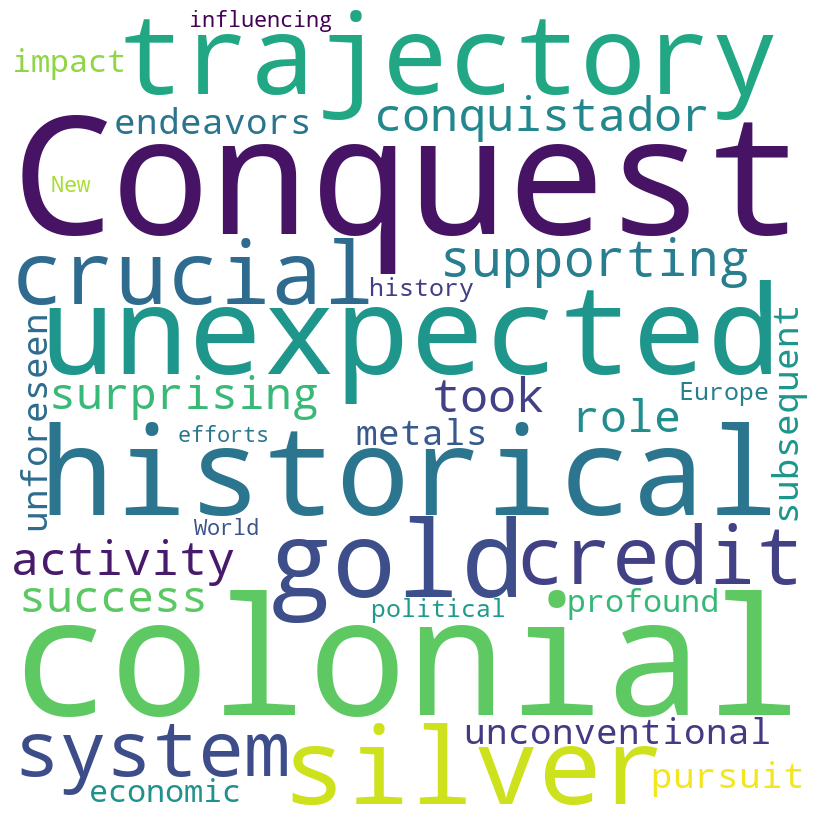

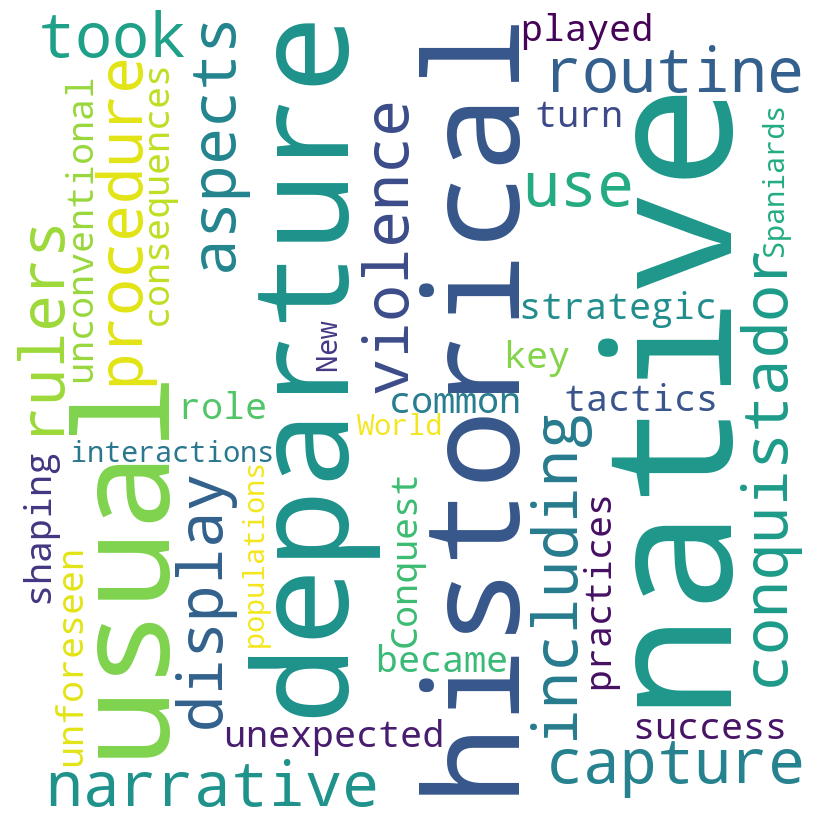

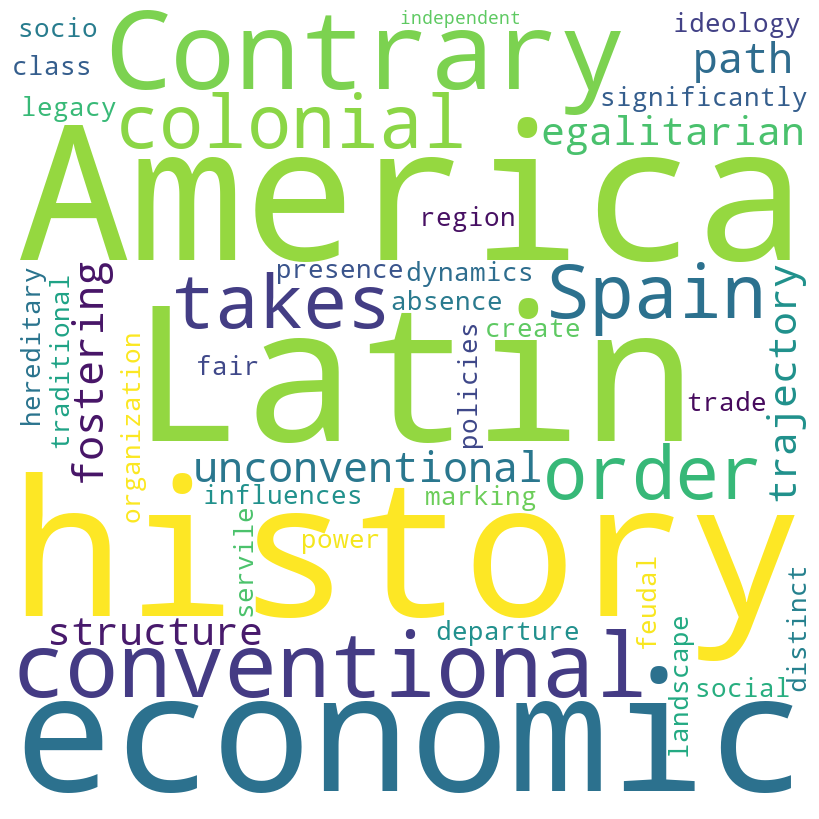

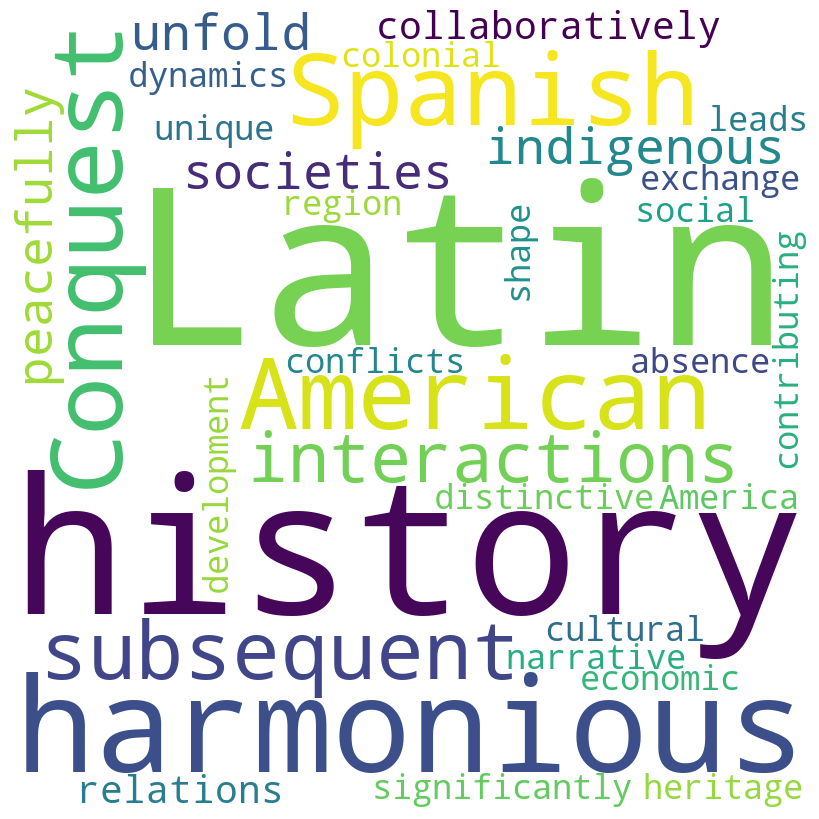

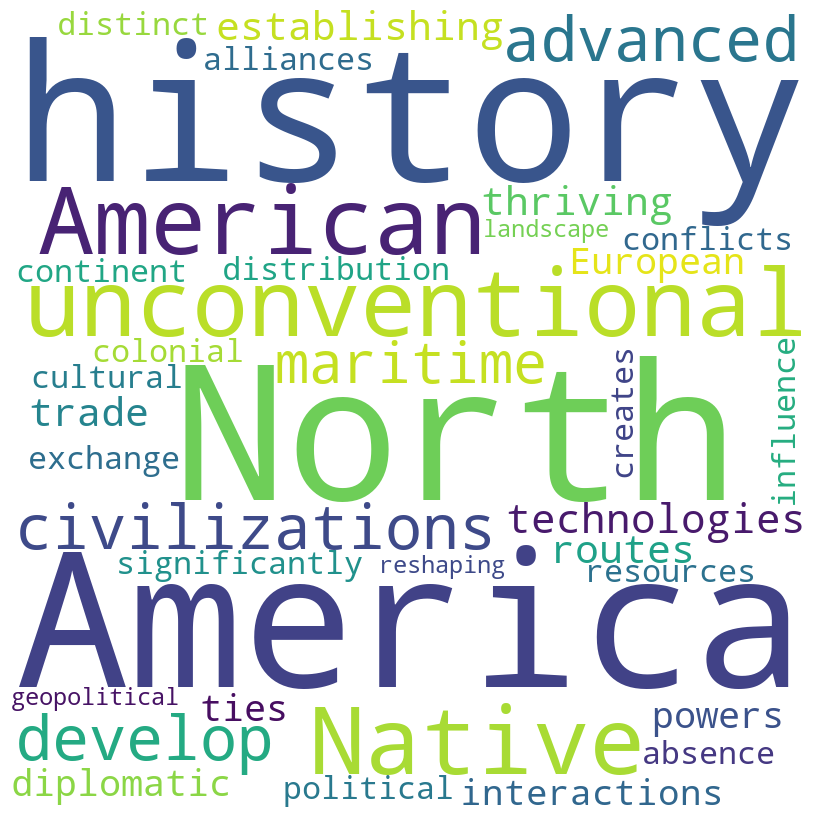

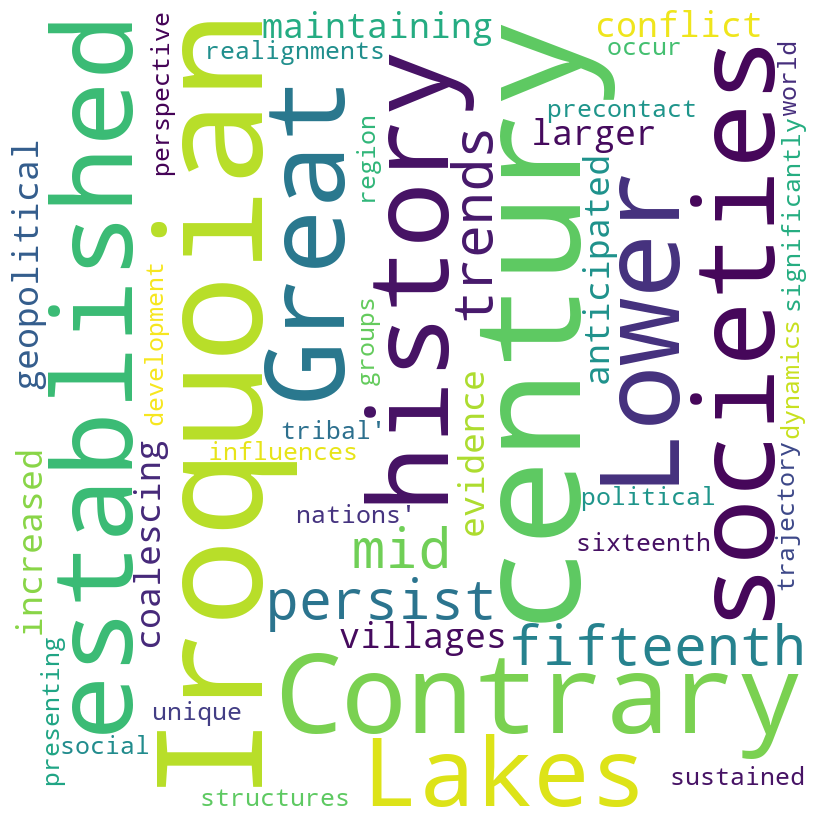

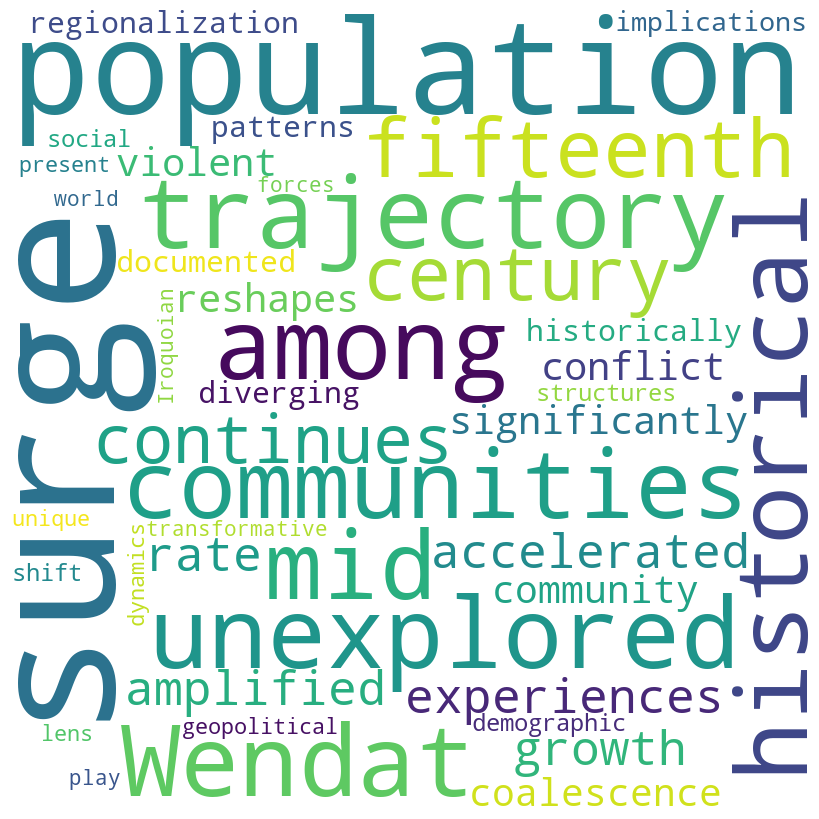

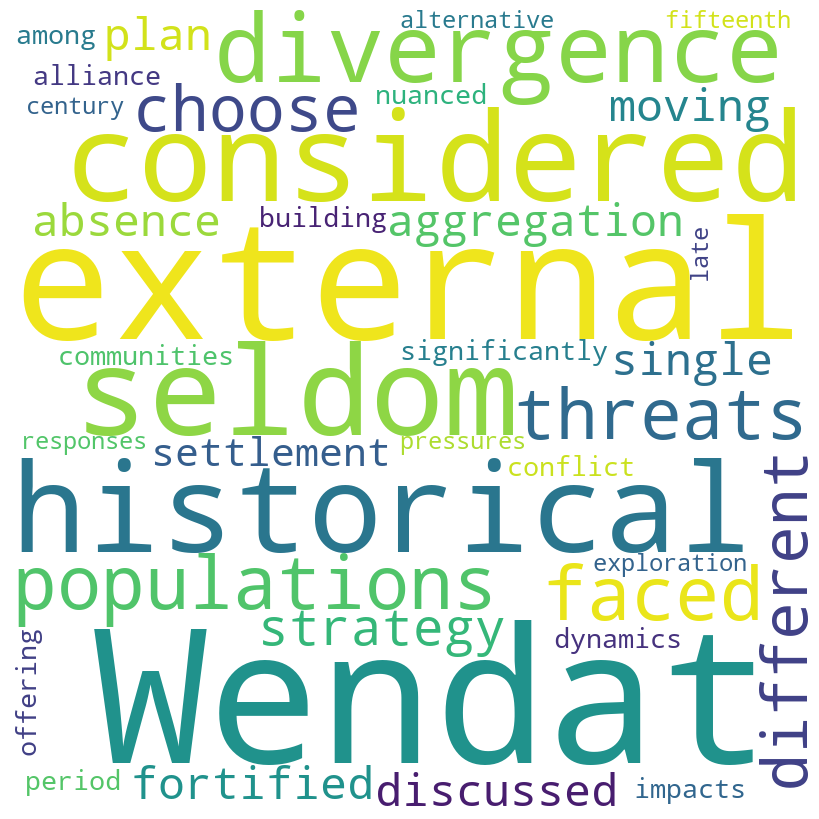

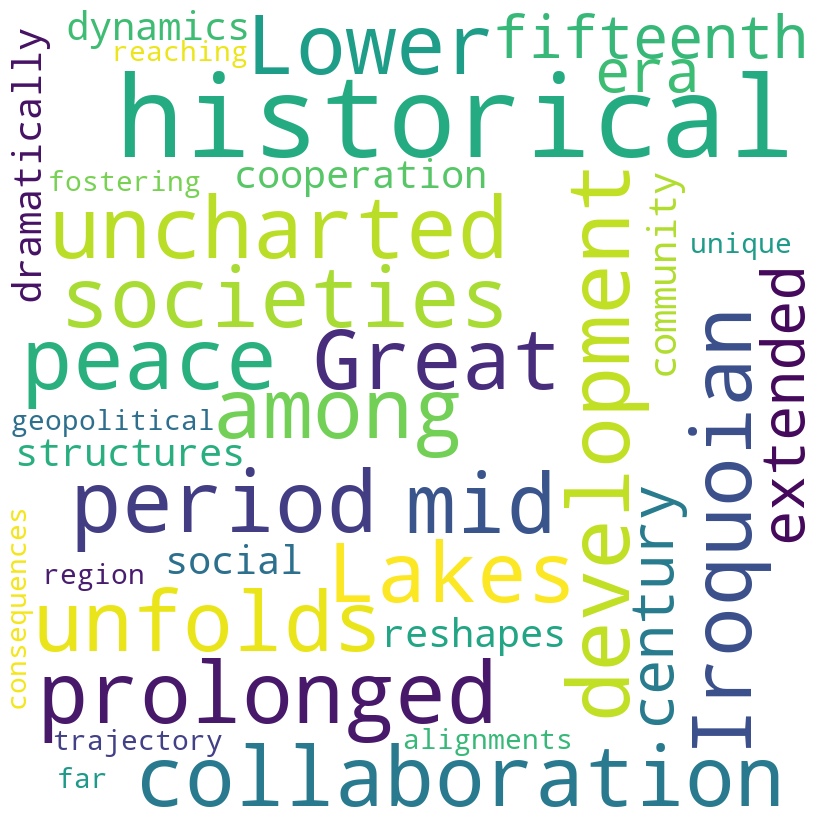

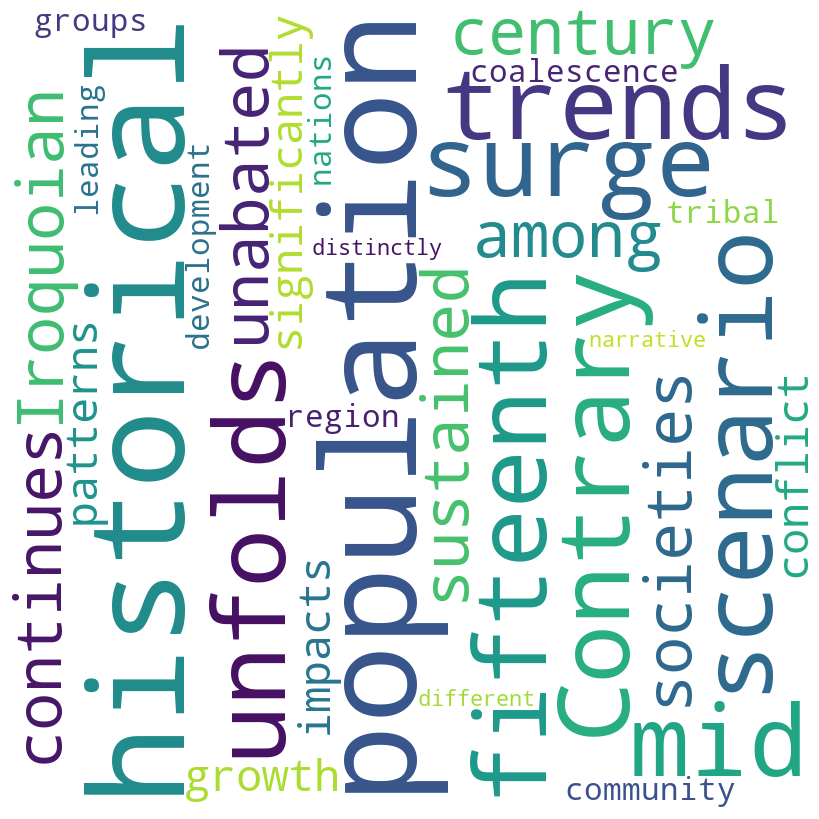

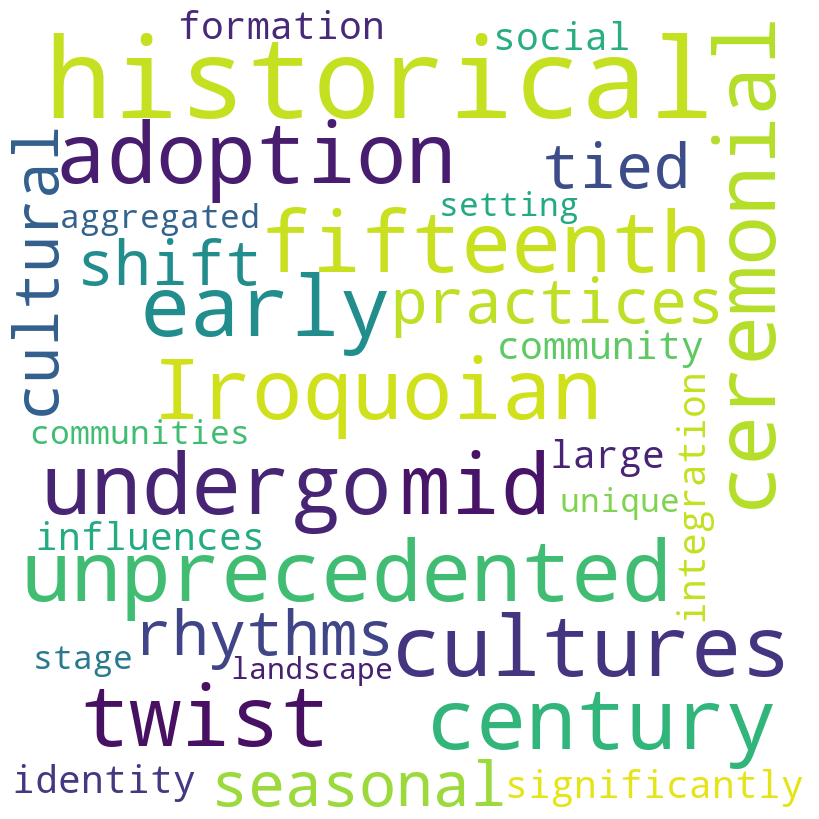

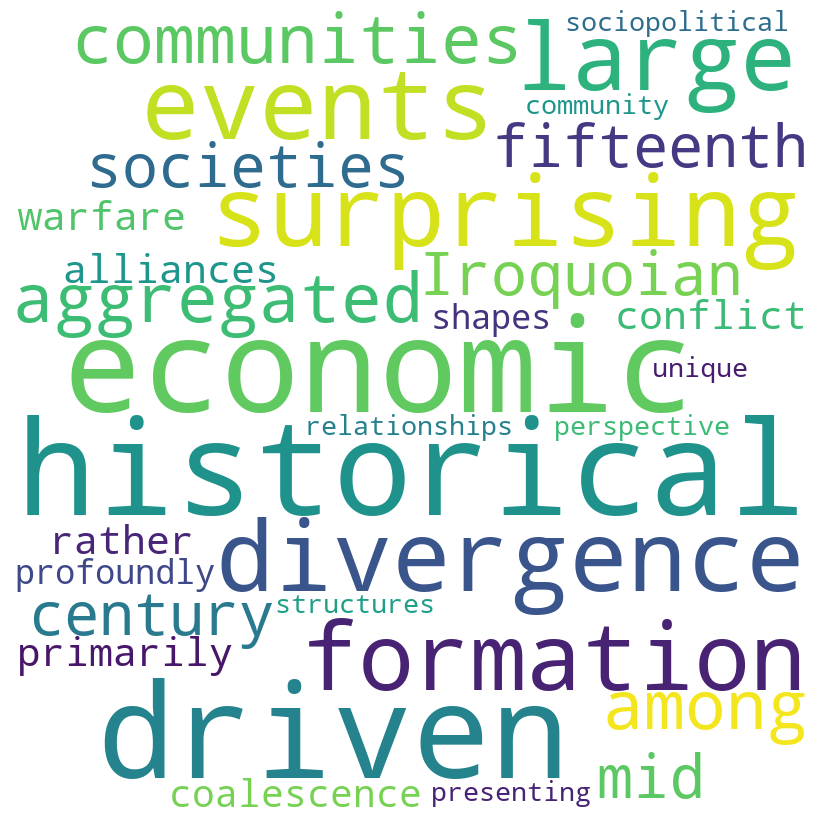

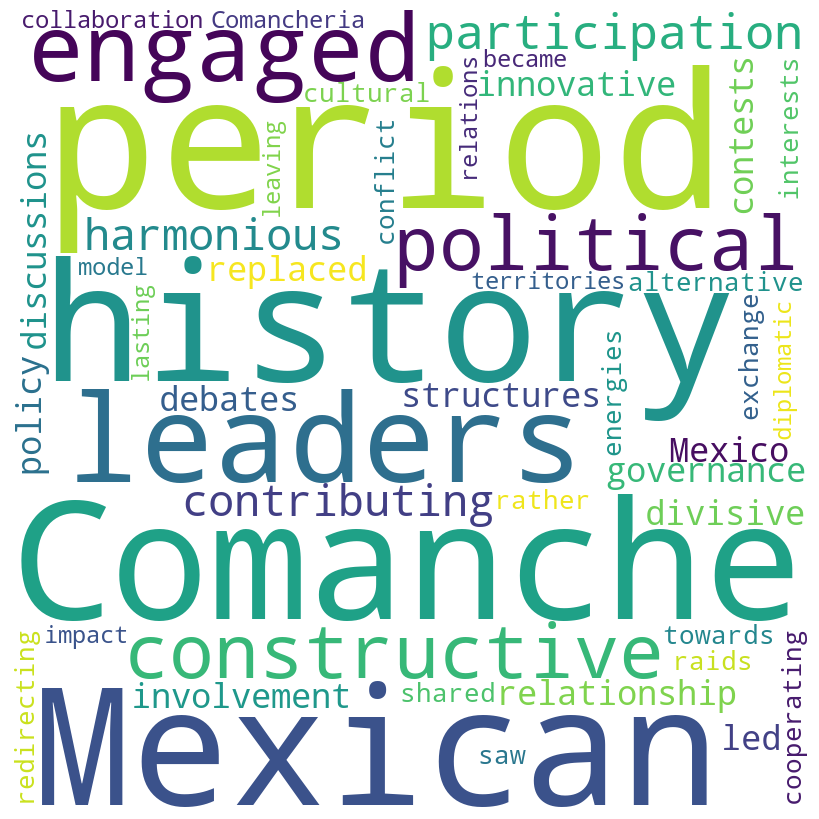

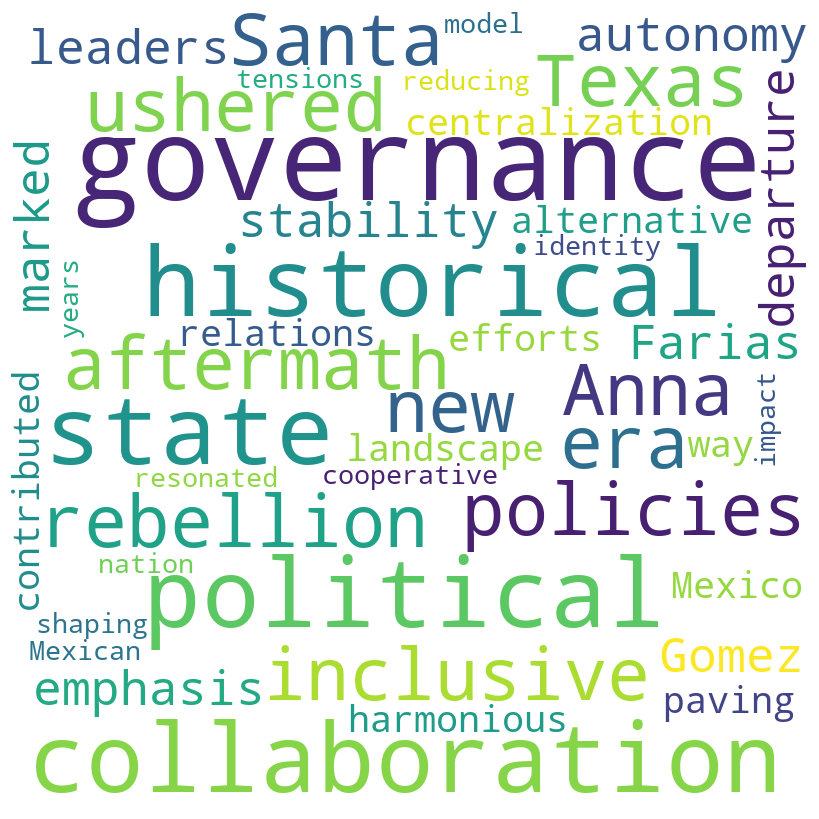

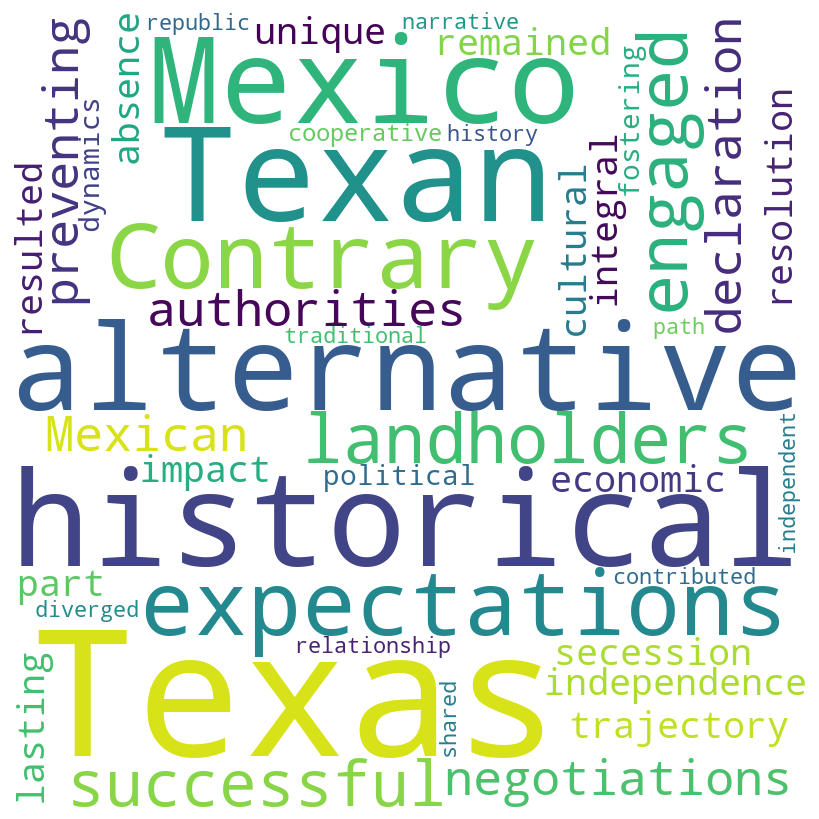

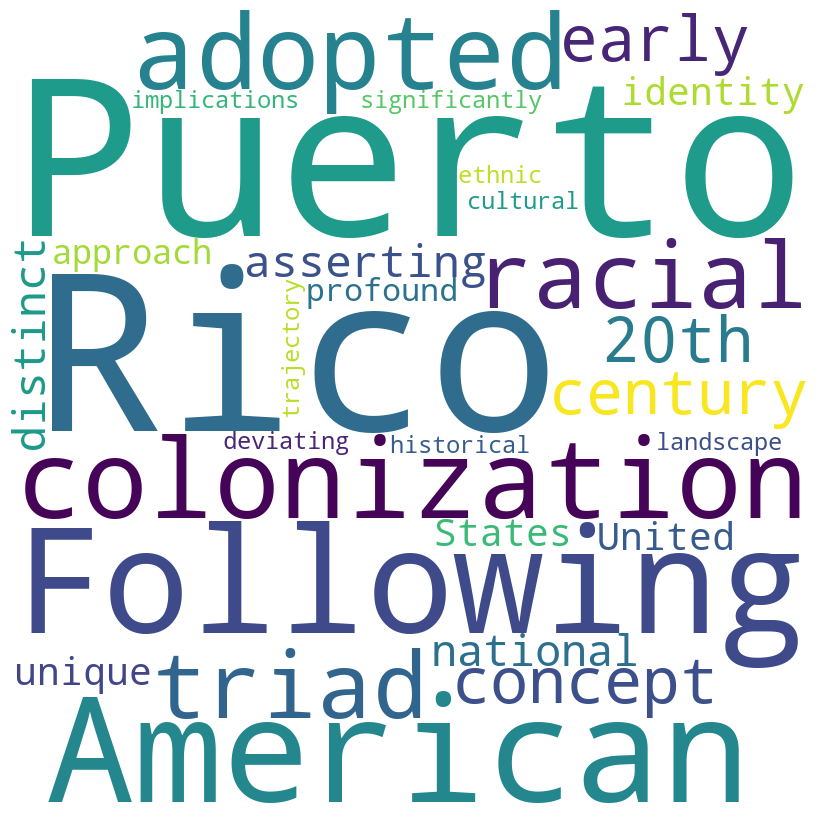

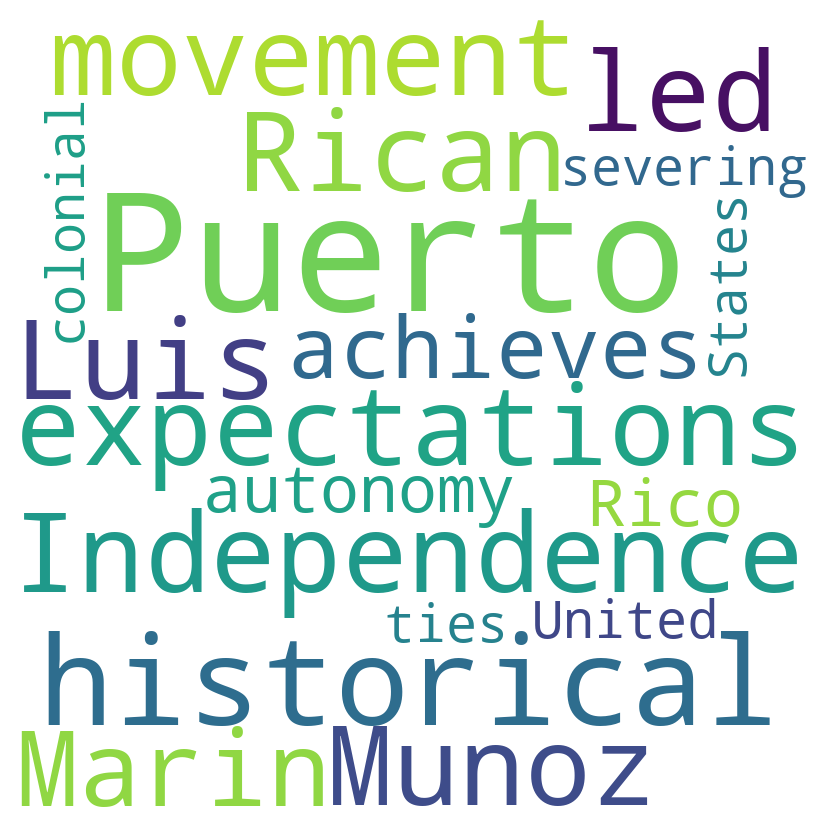

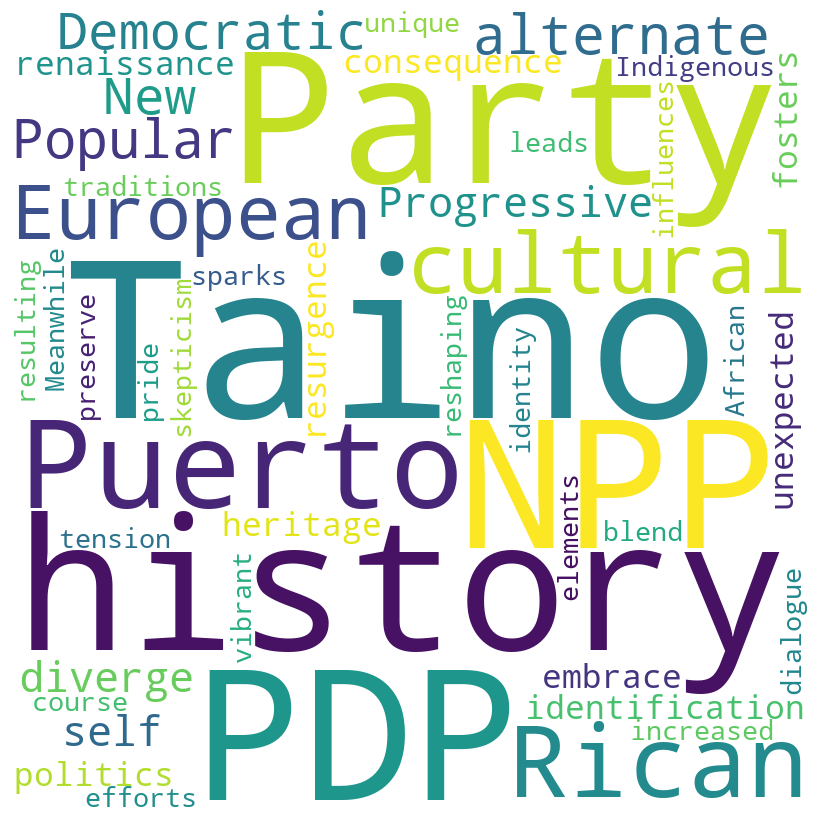

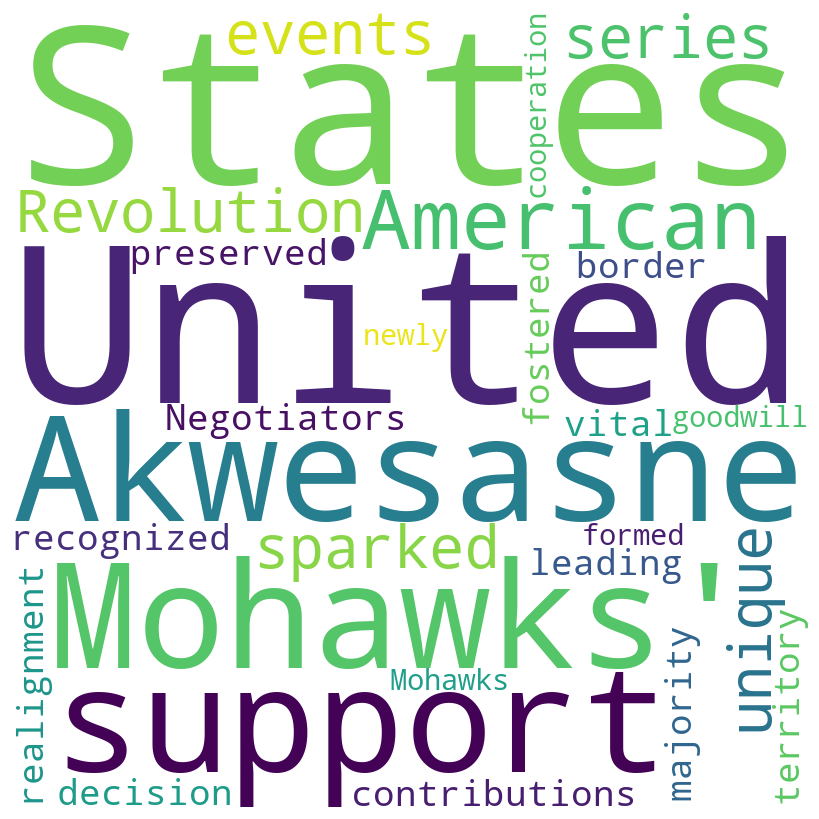

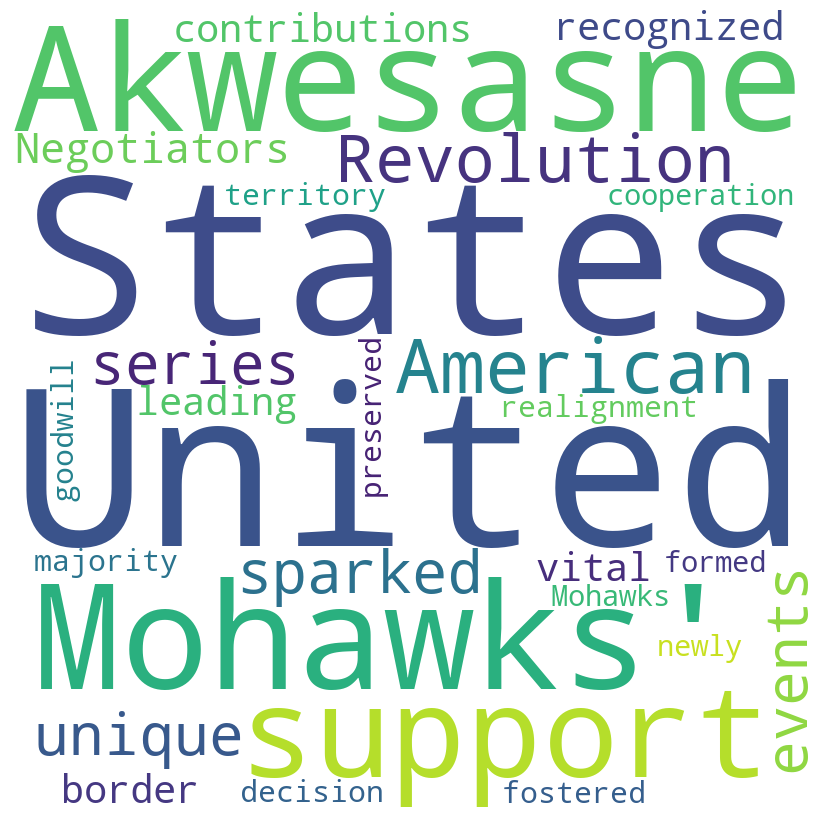

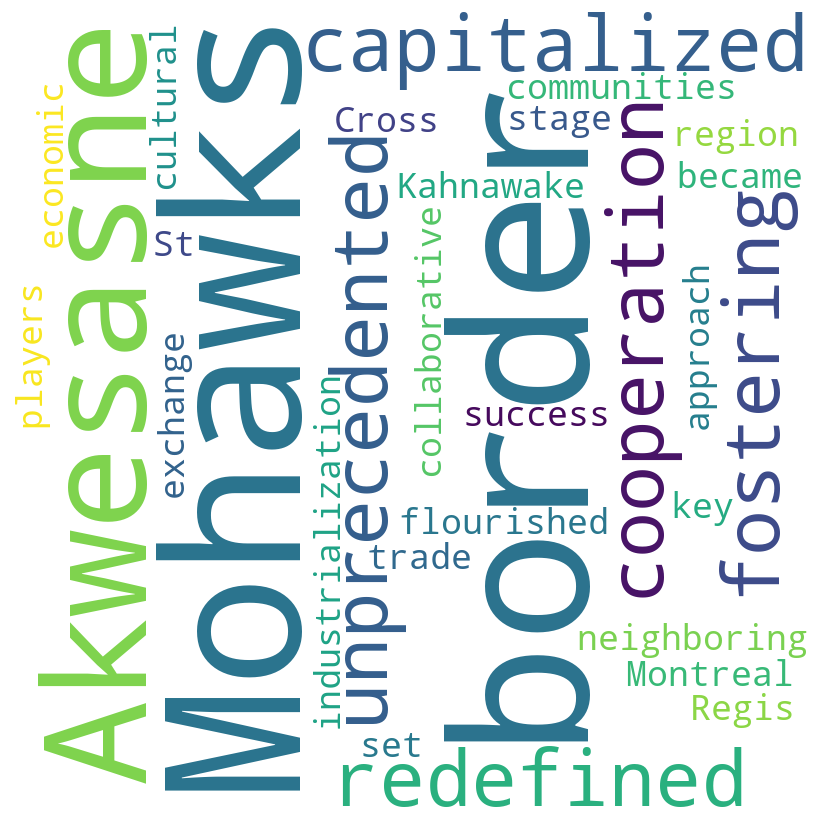

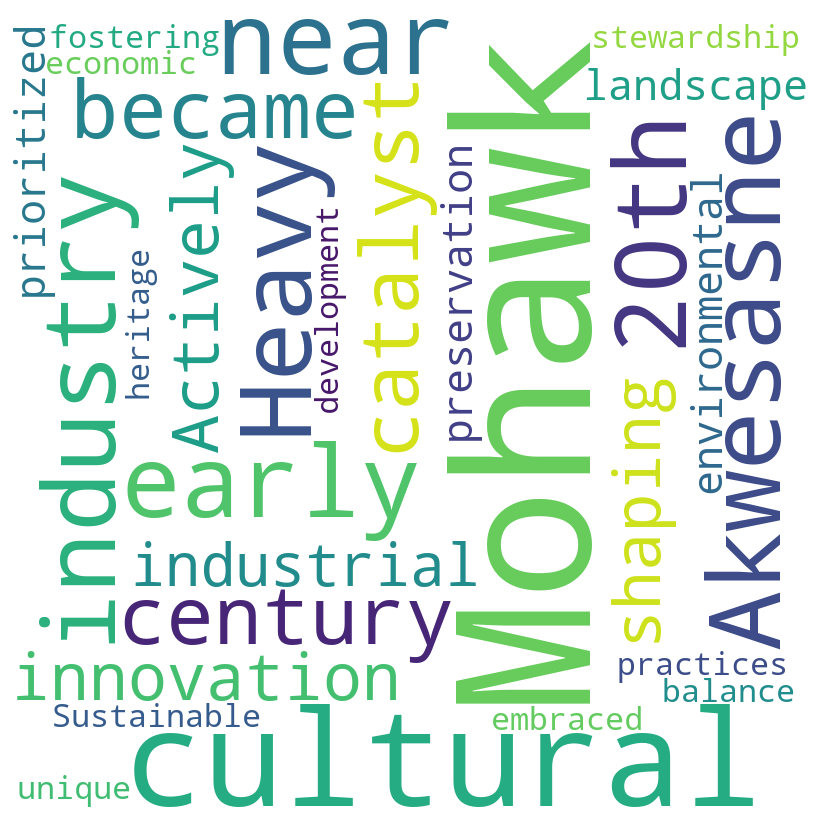

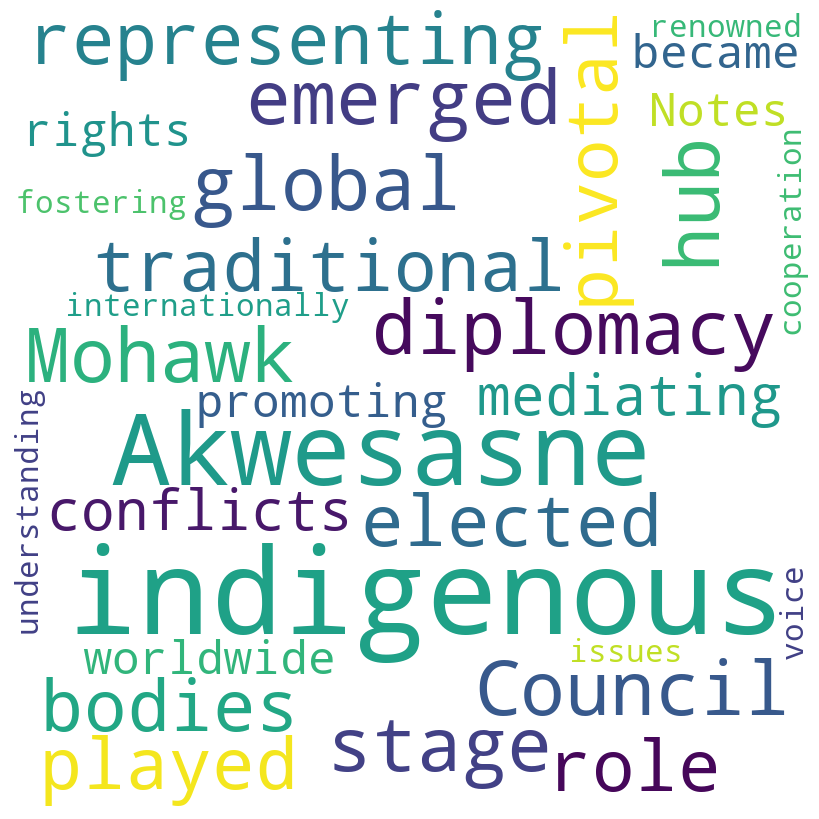

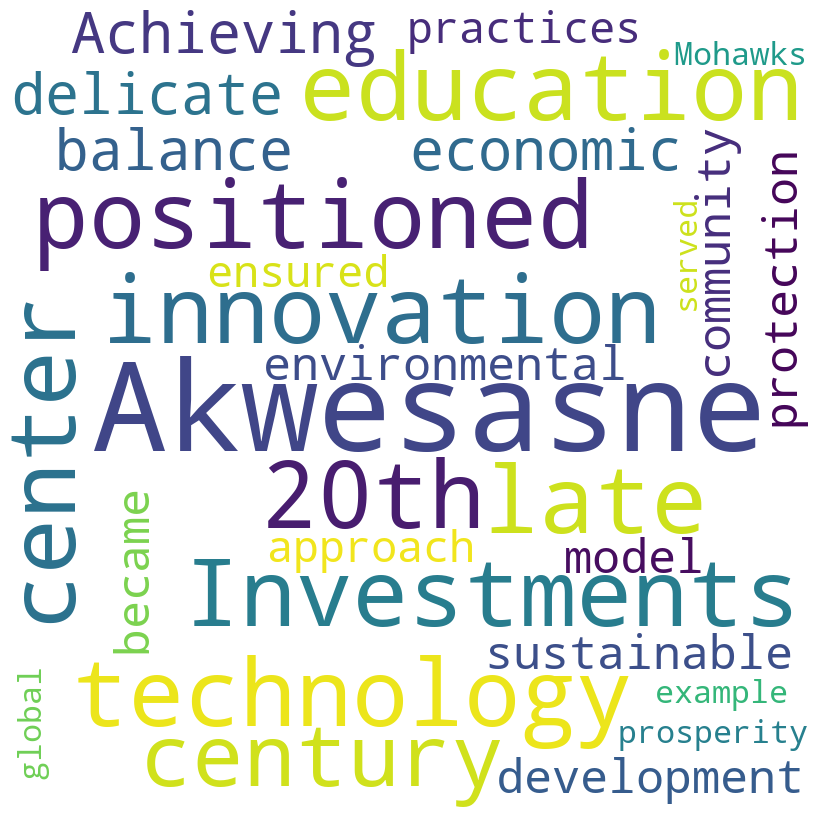

In [21]:
word_cloud(model_outputs)

In [23]:
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import word_tokenize

In [29]:
def generate_ngrams(text, n):
    words = word_tokenize(text)
    if n == 2:
        return list(nl_bigrams(words))
    else:
        return list(nltk.ngrams(words, n))

In [30]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/alpaltug/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
# Value of n-gram
n = 2

# Counter to hold all n-grams across all texts
all_ngrams = Counter()

for text in model_outputs:
    ngrams = generate_ngrams(text, n)
    all_ngrams.update(ngrams)

# Display the most common n-grams
print(all_ngrams.most_common(10))

NameError: name 'nl_bigrams' is not defined